In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [103]:
# Parameters
n = 30 # dimension of actions and/or cost matrix
d = 500 # number of initial sample pairs
total_samples = 10000 # number of total samples that can be used
buff_size = 500 # buffer size of D to make use of newer experiences and limiting the effect of old ones by popping them
alpha = 0.01 # learning rate for when performing gradient descent on b

In [2]:
# setting the random seed
np.random.seed(42)
torch.manual_seed(42)

In [153]:
# Define what you want R to be
R = np.identity(n) # identity matrix
# R = generate_diagonally_dominant_positive_definite_matrix(n)
# R = torch.tensor(R, dtype=torch.float32)

In [104]:
# Initialize b to all 2.0s
b = torch.tensor([2.0]*n, requires_grad=True)

In [101]:
# Initialize D to be empty
D = []

In [3]:
def generate_diagonally_dominant_positive_definite_matrix(size):
    A = np.random.rand(size, size)
    A = A + np.diag(np.sum(np.abs(A), axis=1) + 1)
    A = (A + A.T)/2
    return A

In [105]:
# Cost (reward) function a transpose R a
def reward(a, R):
    return torch.matmul(torch.matmul(a.T,R), a)

In [106]:
# generate a random action given the target parameter b s.t. a = b + N(0,1) (make sure a has entries only [-2,2])
def generate_action(b):
    a = b + torch.normal(0,1,(n,))
    return torch.clamp(a, -2, 2)

In [47]:
# Function for gradient clipping
def clip_gradients(theta, max_norm):
    torch.nn.utils.clip_grad_norm_(theta, max_norm)

In [111]:
optimizer = optim.Adam(Q.parameters(), lr=0.01)
optimizer1 = optim.Adam(Q.parameters(), lr=0.001)

In [148]:
# Function to update the parameters of Q with one step of gradient descent
def update_Q(minibatch, learning_rate, max_norm=None, optimizer):
    optimizer.zero_grad()  # Reset gradients to zero before backward pass
    loss = Q.loss(minibatch)
    loss.backward(retain_graph=True)  # Perform backpropagation
    if max_norm is not None:
        clip_gradients(Q.parameters(), max_norm=max_norm)  # Gradient clipping

    if optimizer is not None:
        optimizer.step()
    else:
        # Manually update the parameters
        with torch.no_grad():  # Disable gradient tracking to perform manual updates
            for param in Q.parameters():
                param -= learning_rate * param.grad  # Update parameters using gradient descent

In [164]:
# Function to update the parameters of b with one step of gradient descent
def update_b():
    # To update b, we need to calculate the gradient w.r.t. to it from the Q network's output (use gradient clipping)
    b_grad = torch.autograd.grad(Q(b.unsqueeze(0)), b, create_graph=True)[0]
    with torch.no_grad():  # Update b without tracking gradients
        b.sub_(alpha * b_grad)
        # Clip gradients
        b_grad_norm = b_grad.norm()



In [150]:
# Defining simple MLP for Q where we can change the number of layers and the number of neurons in each layer
class Q_theta(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Q_theta, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

    def loss(self, minibatch):
        loss = 0.0
        for a,r in minibatch:
            loss += (self.forward(a) - r)**2
        loss = loss/len(minibatch)
        return loss

# Initialize Q with random weights
Q = Q_theta(n, 1, 64)

In [167]:
# Algorithm
def BaseMLP():
    global D, b, Q, R

    # list to store the costs to graph them
    costs1 = []

    for iter in range(10):
        # change the seed
        np.random.seed(iter)
        torch.manual_seed(iter)
        # Generate initial sample pairs
        for i in range(d):
            a = generate_action(b)
            r = reward(a, R)
            D.append((a,r))

        for i in range(total_samples - d):

            # generate a random action
            a = generate_action(b)

            # get the reward
            r = reward(a, R)

            # add the new sample pair to D
            D.append((a,r))

            # sample a minibatch from D
            minibatch = random.sample(D, 32)

            # update Q with one step of gradient descent
            update_Q(minibatch, 0.01, 1.0)

            # update b with one step of gradient descent
            update_b()

        # store the cost
        costs1.append(reward(b, R))

    # Return the final b
    return costs1

In [ ]:
# Variant 1: BaseMLP with dynamic buffer 
def MLP1():
    global D, b, Q, R

    # list to store the costs to graph them
    costs2 = []

    for iter in range(10):
        # change the seed
        np.random.seed(iter)
        torch.manual_seed(iter)
        # Generate initial sample pairs
        for i in range(d):
            a = generate_action(b)
            r = reward(a, R)
            D.append((a,r))

        for i in range(total_samples - d):

            # generate a random action
            a = generate_action(b)

            # get the reward
            r = reward(a, R)

            # add the new sample pair to D
            D.append((a,r))

            # pop the oldest sample pair from D if the buffer is full
            if len(D) > buff_size:
                D.pop(0)

            # sample a minibatch from D
            minibatch = random.sample(D, 32)

            # update Q with one step of gradient descent
            update_Q(minibatch, 0.01, 1.0)

            # update b with one step of gradient descent
            update_b()

        costs2.append(reward(b, R))

    # return the costs and the final b
    return costs2

In [ ]:
# variant 2: BaseMLP with dynamic buffer and optimized gradient descent
def MLP2():
    global D, b, Q, R

    # list to store the costs to graph them
    costs3 = []

    for iter in range(10):
        # change the seed
        np.random.seed(iter)
        torch.manual_seed(iter)
        # Generate initial sample pairs
        for i in range(d):
            a = generate_action(b)
            r = reward(a, R)
            D.append((a,r))

        # Main loop
        for i in range(total_samples - d):

            # generate a random action
            a = generate_action(b)

            # get the reward
            r = reward(a, R)

            # add the new sample pair to D
            D.append((a,r))

            # pop the oldest sample pair from D if the buffer is full
            if len(D) > buff_size:
                D.pop(0)

            # sample a minibatch from D
            minibatch = random.sample(D, 32)

            # update Q with one step of gradient descent
            update_Q(minibatch, 0.01, 1.0)

            # update b with one step of gradient descent
            update_b()

        costs3.append(reward(b, R))

    # return the costs 
    return costs3

In [ ]:
# variant 3: BaseMLP with dynamic buffer and optimized gradient descent and a different neural network architecture
def MLP3():
    global D, b, Q, R

    # list to store the costs to graph them
    costs4 = []

    for iter in range(10):
        # change the seed
        np.random.seed(iter)
        torch.manual_seed(iter)
        # Generate initial sample pairs
        for i in range(d):
            a = generate_action(b)
            r = reward(a, R)
            D.append((a,r))

        # Main loop
        for i in range(total_samples - d):

            # generate a random action
            a = generate_action(b)

            # get the reward
            r = reward(a, R)

            # add the new sample pair to D
            D.append((a,r))

            # pop the oldest sample pair from D if the buffer is full
            if len(D) > buff_size:
                D.pop(0)

            # sample a minibatch from D
            minibatch = random.sample(D, 32)

            # update Q with one step of gradient descent
            update_Q(minibatch, 0.01, 1.0)

            # update b with one step of gradient descent
            update_b()

        costs4.append(reward(b, R))

    # return the costs 
    return costs4

In [ ]:
# variant 4: BaseMLP with dynamic buffer and optimized gradient descent and a different neural network architecture and a different learning rate
def MLP4():
    global D, b, Q, R

    # list to store the costs to graph them
    costs5 = []

    for iter in range(10):
        # change the seed
        np.random.seed(iter)
        torch.manual_seed(iter)
        # Generate initial sample pairs
        for i in range(d):
            a = generate_action(b)
            r = reward(a, R)
            D.append((a,r))

        # Main loop
        for i in range(total_samples - d):

            # generate a random action
            a = generate_action(b)

            # get the reward
            r = reward(a, R)

            # add the new sample pair to D
            D.append((a,r))

            # pop the oldest sample pair from D if the buffer is full
            if len(D) > buff_size:
                D.pop(0)

            # sample a minibatch from D
            minibatch = random.sample(D, 32)

            # update Q with one step of gradient descent
            update_Q(minibatch, 0.01, 1.0, optimizer)

            # update b with one step of gradient descent
            update_b()

        costs5.append(reward(b, R))

    # return the costs 
    return costs5

In [ ]:
# variant 5: BaseMLP with dynamic buffer and optimized gradient descent and a different neural network architecture and a different learning rate and a different buffer size
def MLP5():
    global D, b, Q, R

    # list to store the costs to graph them
    costs6 = []

    for iter in range(10):
        # change the seed
        np.random.seed(iter)
        torch.manual_seed(iter)
        # Generate initial sample pairs
        for i in range(d):
            a = generate_action(b)
            r = reward(a, R)
            D.append((a,r))

        # Main loop
        for i in range(total_samples - d):

            # generate a random action
            a = generate_action(b)

            # get the reward
            r = reward(a, R)

            # add the new sample pair to D
            D.append((a,r))

            # pop the oldest sample pair from D if the buffer is full
            if len(D) > buff_size:
                D.pop(0)

            # sample a minibatch from D
            minibatch = random.sample(D, 32)

            # update Q with one step of gradient descent
            update_Q(minibatch, 0.01, 1.0, optimizer)

            # update b with one step of gradient descent
            update_b()

        costs6.append(reward(b, R))

    # return the costs 
    return costs6

/var/folders/22/nrb4t9gx0n9bfqq_y59_73p80000gn/T/ipykernel_23163/1732713168.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R_tensor = torch.tensor(R, dtype=torch.float32)


[1576.1185302734375, 677.1021728515625, 842.2159423828125, 1717.442626953125, 895.9251708984375, 1056.2325439453125, 842.4500732421875, 1214.6629638671875, 895.0425415039062, 998.5892333984375, 786.1927490234375, 1130.357421875, 1352.0538330078125, 1259.755126953125, 726.2926025390625, 886.6927490234375, 523.9493408203125, 1486.6593017578125, 1437.8975830078125, 1296.5860595703125, 938.6829223632812, 908.3196411132812, 1234.955322265625, 1133.48193359375, 1009.05810546875, 796.9384155273438, 934.5453491210938, 1248.7598876953125, 1041.62939453125, 1319.455078125, 556.7021484375, 956.6615600585938, 1061.710693359375, 925.2681274414062, 1408.6707763671875, 1037.0810546875, 756.0641479492188, 1226.73681640625, 714.194580078125, 1099.1434326171875, 1584.2603759765625, 1269.1021728515625, 966.75830078125, 818.962158203125, 1172.3238525390625, 898.3810424804688, 1340.8438720703125, 900.9786376953125, 1359.3734130859375, 1059.7733154296875, 720.2554321289062, 1705.850830078125, 955.5364990234

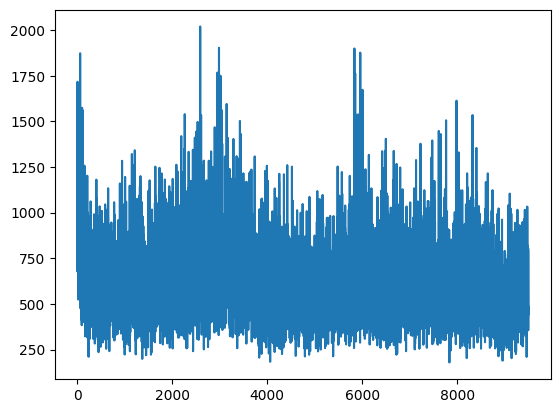

In [166]:
# Run the algorithms
costs1 = BaseMLP()
costs2 = MLP1()
costs3 = MLP2()
costs4 = MLP3()
costs5 = MLP4()
costs6 = MLP5()






